# **Part 1: Import libraries and data processing**


---



## 1.1 Importation of libraries

In [ ]:
!pip install pytorch_lightning -U torchinfo segmentation_models_pytorch

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from os.path import join
import glob
import sys
import random
import warnings
from tqdm import tqdm
import itertools
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from IPython.display import Image
from skimage import io
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import  ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import segmentation_models_pytorch as smp
from torchinfo import summary

seed_everything(42, workers=True)
torch.use_deterministic_algorithms(True)
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"


%matplotlib inline

## 1.2 Dataset download

In [ ]:
!wget https://cluster.ig.umons.ac.be/HackIA21/databases/ADL/dataset.zip
!unzip -q dataset.zip

## 1.3 Function allowing to select a subset of images

In [ ]:
from glob import glob
def create_dataset(subset_size):
    def check_mask(mask_path):
      img = cv2.imread(mask_path)
      max_val = img.max()
      if max_val > 0:
          return 1
      else:
          return 0
    patients = [ d for d in os.listdir('./dataset/') if os.path.isdir(os.path.join('./dataset/', d))]
    # Collect mask files and train files
    mask_files = [f for p in patients for f in glob(f'./dataset/{p}/*_mask*')]
    train_files = [m.replace('_mask', '') for m in mask_files]

    # Create DataFrame
    df = pd.DataFrame({"image_path": train_files, "mask_path": mask_files})

    df['mask'] = df['mask_path'].apply(lambda x: check_mask(x))

    if subset_size:
      df, _ = train_test_split(df,train_size=subset_size,stratify=df["mask"],random_state=123)
      df.reset_index(inplace=True)
    return df

## **Q1 : Select a subset of 1000 images and check the balance between the two classes**

In [ ]:
#########################################################################################
#########################################################################################

## 1.4 Data division : 10% for test dataset

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=2)

## 1.5 Data division : 20% for validation dataset

In [ ]:
# validation split
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=2)
print("Train shape: {}\nTest shape: {}\nValidation shape: {}".format(df_train.shape, df_test.shape, df_val.shape))

## 1.6 Define customDataset

In [ ]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
import cv2
import torch

def adjust_data(img, mask):
    """
    - Normalize image (0-1 range).
    - Binarize mask.
    """
    img = img / 255.0
    mask = mask / 255.0
    mask[mask > 0.5] = 1.0
    mask[mask <= 0.5] = 0.0
    return img, mask

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, data_frame, transform=None, target_size=(256, 256)):
        self.data_frame = data_frame
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Load Image and Mask Paths
        image_path = self.data_frame.iloc[idx]['image_path']
        mask_path = self.data_frame.iloc[idx]['mask_path']

        # Read Image and Mask
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize Image and Mask
        image = cv2.resize(image, self.target_size)
        mask = cv2.resize(mask, self.target_size)

        # Adjust Data
        image, mask = adjust_data(image, mask)

        # Apply Augmentations if any
        if self.transform:
            image = self.transform(image).float()
            mask = self.transform(mask).float()

        return image, mask

## 1.7 Create dataloaders

In [ ]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Create Datasets
train_dataset = CustomDataset(df_train, transform=image_transform, target_size=(256, 256))
val_dataset = CustomDataset(df_val, transform=image_transform, target_size=(256, 256))
test_dataset = CustomDataset(df_test, transform=image_transform, target_size=(256, 256))

# Create DataLoaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

# Example usage
for images, masks in train_loader:
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)
    break

## 1.8 Display some images with labels/masks

In [ ]:
def plotData():
  count = 0
  # generating random number for getting random image
  i = np.random.randint(len(df)-3)

  fig,axes = plt.subplots(3,3, figsize=(20,15))
  for mask in df['mask']:
      # plot only if the generated random index mask is 1
      if df.iloc[i]['mask'] == 1:

          print("Image id: {}".format(i))
          img = io.imread(df.image_path[i])
          axes[count][0].title.set_text("Brain MRI")
          axes[count][0].imshow(img)

          mask = io.imread(df.mask_path[i])
          axes[count][1].title.set_text("Mask =" + str(df['mask'][i]))
          axes[count][1].imshow(mask, cmap='gray')

          img[mask==255] = (255,0,0)  # change pixel color at the position of mask
          axes[count][2].title.set_text("MRI with Mask =" + str(df['mask'][i]))
          axes[count][2].imshow(img)
          count +=1
      i += 1
      if (count==3):
          break

  fig.show()

In [ ]:
plotData()

# **Part 2 : Image segmentation with image processing via otsu method**


---



## 2.1 Define the image processing function :  OTSU segmentation


In [ ]:
def otsu_segmentation(df, id):
    img = cv2.imread(df.iloc[id].image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Load mask
    mask = cv2.imread(df.iloc[id].mask_path, 0)

    # Apply Otsu's thresholding (segmentation)
    img_gray = cv2.imread(df.iloc[id].image_path, 0)
    _, mask_otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Overlay Otsu's segmentation on the image
    overlay_otsu = img.copy()
    overlay_otsu[mask_otsu == 255] = (255, 0, 0)

    # Overlay mask on the original image
    overlay_gt = img.copy()
    overlay_gt[mask == 255] = (0, 255, 0)  # Green for correct mask

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(overlay_otsu)
    plt.title("Otsu Segmentation")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_gt)
    plt.title("Ground Truth Mask")

    plt.show()

## **Q2 : Apply Otsu segmentation & analyse results**

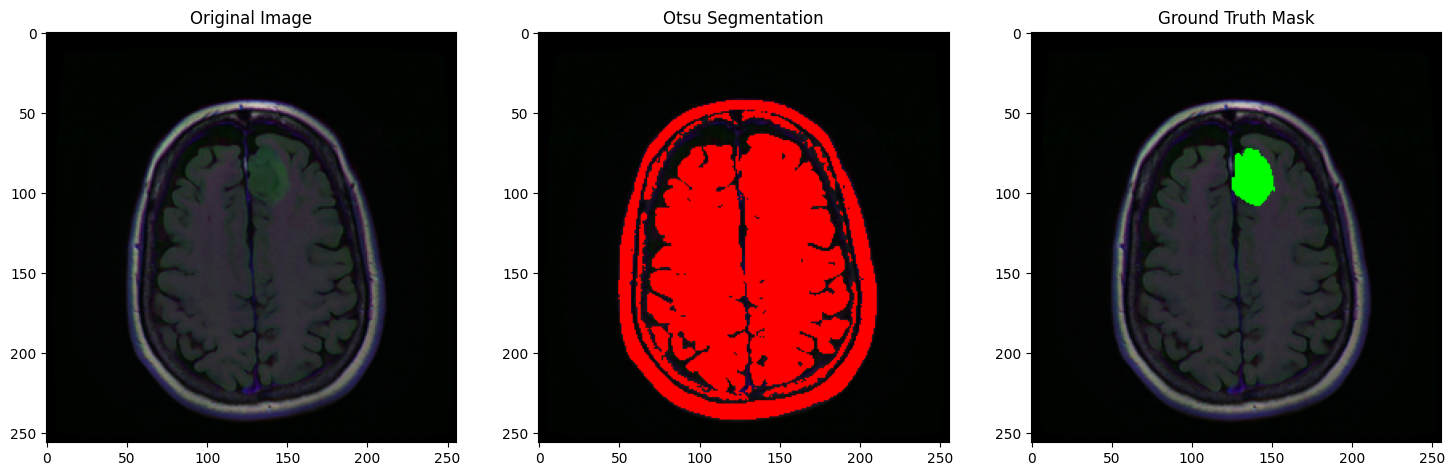

In [ ]:
#################################################################################

# **Part 3: Image segmentation using deep learning**


---

## 3.1 Model evaluation function: plot predictions on test set samples

In [ ]:
def evaluate_model(model, df_test):

    # Check and reset index if not sequential
    if not (df_test.index == pd.RangeIndex(start=0, stop=len(df_test), step=1)).all():
        df_test = df_test.reset_index(drop=True)

    # Select 15 examples with tumor ('mask' == 1)
    indexes = df_test[df_test['mask'] == 1].iloc[:15].index

    for idx in indexes:
        # Load image and mask
        img = cv2.imread(df_test.loc[idx, 'image_path'], cv2.IMREAD_COLOR)
        mask = cv2.imread(df_test.loc[idx, 'mask_path'], cv2.IMREAD_GRAYSCALE)


        img = cv2.resize(img, (256, 256))
        mask = cv2.resize(mask, (256, 256))  # Ensure mask is same size
        original_img = img.copy()  # Keep a copy for visualization

        # Normalize and prepare input image
        img_input = img / 255.0
        img_input = np.transpose(img_input, (2, 0, 1))  # (H, W, C) -> (C, H, W)
        img_input = img_input[np.newaxis, :, :, :]  # Add batch dimension

        # Convert to torch tensor and predict
        with torch.no_grad():
            input_img = torch.tensor(img_input).float()
            pred = model.predict_step(input_img, 0)


        pred_binary = pred.detach().cpu().numpy().squeeze().astype(np.uint8)  # convert to numpy array and cast it to int type

        pred_overlay = original_img.copy()
        pred_overlay[pred_binary == 1] = [255, 0, 0]  # Red for predicted mask

        true_overlay = original_img.copy()
        true_overlay[mask == 255] = [0, 255, 0]  # Green for true mask

        plt.figure(figsize=(12, 12))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.title("Original Image (id = " + str(idx) + ")")

        plt.subplot(1, 3, 2)
        plt.imshow(true_overlay)
        plt.title("True Mask (Green Overlay)")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_overlay)
        plt.title("Prediction Mask (Red Overlay)")

        plt.tight_layout()
        plt.show()


## 3.2 BaseModel class definition

In [ ]:
import collections
class SegModel(pl.LightningModule):
    def __init__(self,model,loss_fn):
        super().__init__()
        self.save_hyperparameters(ignore=['model',"loss_fn"])
        self.model = model
        self.loss_fn = loss_fn

        # Lists to accumulate outputs for each epoch
        self.train_outputs = []
        self.valid_outputs = []
        self.test_outputs = []

    def forward(self, image):
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch[0]
        mask = batch[1]

        assert mask.max() <= 1.0 and mask.min() >= 0


        preds = self(image)

        if isinstance(preds, collections.OrderedDict):
            preds = preds["out"]
        loss = self.loss_fn(preds, mask)

        #prob_mask = logits_mask.sigmoid()

        pred_mask = torch.where(preds > 0.5, 1, 0).float()


        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn}

    def shared_epoch_end(self, outputs, stage):
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        total_loss = sum(x['loss'].item() for x in outputs) / len(outputs)

        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro-imagewise")

        metrics = {
            f"{stage}_loss":total_loss,
            f"{stage}_accuracy": accuracy,
            f"{stage}_iou": iou,
        }

        self.log_dict(metrics,on_step=False, on_epoch=True, prog_bar=True)

    # Training Step
    def training_step(self, batch, batch_idx):
        output = self.shared_step(batch, "train")
        self.train_outputs.append(output)  # Store outputs for the epoch
        return output["loss"]

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.train_outputs, "train")
        self.train_outputs.clear()  # Clear memory for the next epoch

    # Validation Step
    def validation_step(self, batch, batch_idx):
        output = self.shared_step(batch, "val")
        self.valid_outputs.append(output)
        return output

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.valid_outputs, "val")
        self.valid_outputs.clear()

    # Test Step
    def test_step(self, batch, batch_idx):
        output = self.shared_step(batch, "test")
        self.test_outputs.append(output)
        return output

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_outputs, "test")
        self.test_outputs.clear()

    # Needed for making predictions at inference
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        output = self(batch)
        if isinstance(output, collections.OrderedDict):
            output = output["out"]  # used only for deeplabv3 format
        pred_mask = torch.where(output > 0.5, 1, 0).float()
        return pred_mask


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)


# **Part 3.1: Image segmentation with a baseline model "SIMPLE CNN" architecture**


---

## **Q3: Define simple CNN model (TO COMPLETE)**

In [ ]:
class SimpleCNN(nn.Module):
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################

## **Q4: Check and visualize your model architecture**

In [ ]:
simple_model = SimpleCNN()
###############################################################################

## **Q5: Train and test your CNN model**

hint : you can use loss function by instanciating from smp.losses.DiceLoss like follows:

```
loss_fn=smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=False)

```



In [ ]:
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################

## **Q6 : Evaluate your model with "evaluate_model" function**

In [ ]:
###############################################################################

# **Part 3.2: Image segmentation with UNet architecture**


---

## **Q7 : Apply the same segmentation process with UNET architecture**

In [ ]:
# Define UNET architecture (look at lab3 statement)
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################

In [ ]:
# Check & Visualize your Unet architecture
###############################################################################
###############################################################################

In [ ]:
# Train and test your Unet model
###############################################################################
###############################################################################

In [ ]:
# Evaluate your Unet model
###############################################################################
###############################################################################

# **Part 3.3: Image segmentation with LinKNet architecture**


---

## **Q8 : Apply the same segmentation process with LinkNet architecture**

In [ ]:
# Define LinkNet architecture (look at lab3 statement)
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################

In [ ]:
# Check & Visualize your LinkNet architecture
###############################################################################
###############################################################################

In [ ]:
# Train and test your LinkNet model
###############################################################################
###############################################################################

In [ ]:
# Evaluate your Linknet model
###############################################################################
###############################################################################

# **Part 3.4: Image segmentation with Deeplabv3 architecture**


---

## **Q9 : Apply the same segmentation process with Deeplabv3 architecture**

In [ ]:
# Define Deeplabv3 architecture (look at lab3 statement)
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################
###############################################################################

In [ ]:
# Check & Visualize your DeepLabv3 architecture
###############################################################################
###############################################################################

In [ ]:
# Train and test your DeepLabv3 model
###############################################################################
###############################################################################

In [ ]:
# Evaluate your Deeplabv3 model
###############################################################################
###############################################################################

# **Part 4: Comparison and analysis**


---

## **Q10 : Provide your experimental and comparison analysis between the five solutions : Otsu, SimpleCNN, Unet, LinkNet, DeeplabV3**

 Provide your textual response here